# 目標
カスタム損失関数（相関係数）で学習させてみる

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json

import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel, custom_loss_function, custom_eval_function
from src.featuring import add_feature

import warnings
warnings.filterwarnings('ignore')

# Config

In [3]:
class cfg:
    exp = "exp004"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    
    model_type = "lightgbm"
    task = "regression"
    model_params = {
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }
    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
# TODO: 特徴量もこの中に入れる
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)


In [4]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")

feature col length: 42


# Load Data

In [5]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)


print(train.shape)
display(train.head(2))


valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)

print(valid.shape)
display(valid.head(2))

(2746270, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2


(3553377, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,2,1,2,2,1,1,2,...,1,2,3,0,2,2,1,3,2,0
n001e1318d5072ac,0575,0.00,1,1,3,2,1,3,3,4,...,2,4,3,2,2,3,1,1,0,1


# Preprocess

In [6]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
valid["era_int"] = valid["era"].astype(int)

cond_train = train["era_int"] % 4 == 0
cond_valid = valid["era_int"] % 4 == 0

train = train.loc[cond_train]
valid = valid.loc[cond_valid]

# Featuring

In [7]:
# train = add_feature(train)
# valid = add_feature(valid)

# Training

In [8]:
features = [col for col in train.columns if "feature" in col]
print(len(features))

42


In [9]:
# model = MLModel(
#     model_type=cfg.model_type,
#     task=cfg.task,
#     model_params=cfg.model_params,
#     custom_loss=lightgbm_correlation_loss
# )
model = LightGBMModel(
    model_params=cfg.model_params,
    custom_loss=custom_loss_function,
    custom_eval=custom_eval_function
)
model.train(
    train[features],
    train["target"],
    eval_set=(valid[features], valid["target"]),
    early_stopping_rounds=10
)

model.save_model(os.path.join(cfg.exp, "model.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 42
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Traini

 
# Validation

In [10]:
valid_pred = model.predict(valid[features])

valid["pred"] = valid_pred

In [11]:
# CORJ60, FNCV3, CORR2OV2, MMC, BMC, CORT20
# meta_model.parquet にはvalidationの最新eraの値が入ってる



meta_model_path = os.path.join(cfg.dataset_path, "meta_model.parquet")
meta_model = pd.read_parquet(meta_model_path)
print(meta_model.shape)
display(meta_model.head())

valid = pd.merge(valid.reset_index(), meta_model.reset_index(), how="left", on=["era", "id"]).set_index("id")
display(valid.head()) 


(75642, 3)


,era,data_type,numerai_meta_model
id,,,
n0001a161ef7f066,1133,validation,0.598030
n000683e569f9b8b,1133,validation,0.760381
n000df72d86f2b54,1133,validation,0.851571
n002303a67dd341c,1133,validation,0.748982
n00251ccb477cbb1,1133,validation,0.833659


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,era_int,pred,data_type,numerai_meta_model
id,,,,,,,,,,,,,,,,,,,,,
n0004e3727abc707,0576,0.25,0,1,2,0,0,0,4,2,...,3,0,0,2,4,1,576,0.500255,NaN,NaN
n0008ecf930b3229,0576,0.50,3,4,3,4,1,0,2,0,...,0,1,4,2,4,0,576,0.510695,NaN,NaN
n0020c1ded3995bd,0576,0.50,1,0,4,0,1,0,0,4,...,1,4,3,0,4,1,576,0.502645,NaN,NaN
n002fd4bd9a3b3c6,0576,0.25,1,4,2,2,1,2,2,2,...,2,1,4,4,4,3,576,0.498678,NaN,NaN
n00301428d7ba61f,0576,0.00,4,2,4,4,1,2,3,3,...,1,3,3,2,3,4,576,0.497189,NaN,NaN


<AxesSubplot: title={'center': 'Validation CORR'}, xlabel='era'>

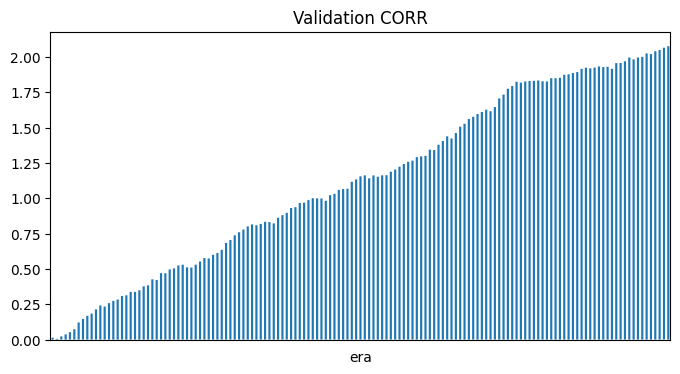

In [12]:

per_era_corr = valid[["era", "target", "pred"]].dropna().groupby("era").apply(
    lambda x: numerai_corr(x[["pred"]].dropna(), x["target"].dropna())
)
# Plot the per-era correlation
per_era_corr.cumsum().plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



In [13]:
per_era_sharpe_ratio = per_era_corr["pred"].mean() / per_era_corr["pred"].std()
print(per_era_sharpe_ratio)

0.9231322406767151


<AxesSubplot: title={'center': 'Validation MMC'}, xlabel='era'>

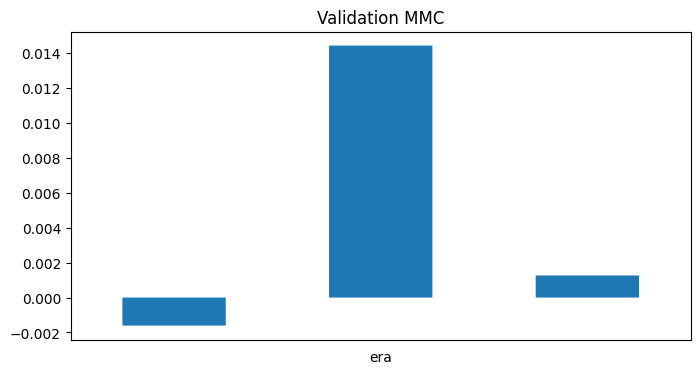

In [14]:

per_era_mmc = valid[["era", "target", "pred", "numerai_meta_model"]].dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["pred"]], x["numerai_meta_model"], x["target"])
)
# Plot the per-era correlation
per_era_mmc.cumsum().plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



In [15]:
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std()
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()
 
mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std()
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "exp": [cfg.exp],
    "corr_mean": [corr_mean.values[0]],
    "corr_std": [corr_std.values[0]],
    "corr_shape": [corr_sharpe.values[0]],
    "corr_max_drawdown": [corr_max_drawdown.values[0]],
    
    "mmc_mean": [mmc_mean.values[0]],
    "mmc_std": [mmc_std.values[0]],
    "mmc_shape": [mmc_sharpe.values[0]],
    "mmc_max_drawdown": [mmc_max_drawdown.values[0]],
})

,exp,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown
0,exp004,0.01451,0.015718,0.923132,0.021222,0.000421,0.014701,0.02867,0.013161


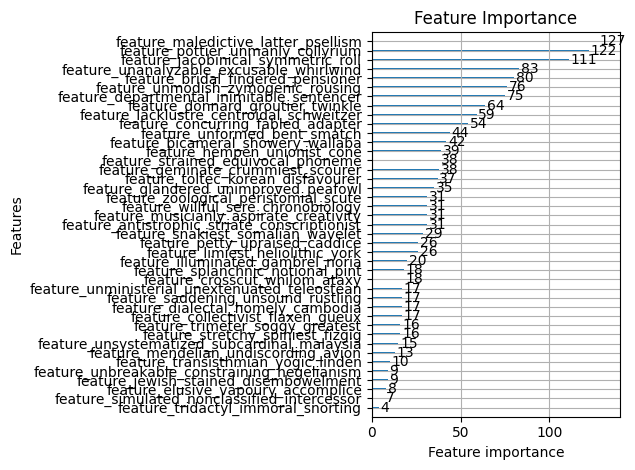

In [16]:
model.visualize_feature_importance()